In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import requests
import datetime 
from datetime import date
from pprint import pprint

## Setting Up the Data

In [2]:
# Regions
file = os.path.join('resources', 'demographics', 'regions.ipynb')
%run '{file}'
# regions_df

#### Training Data

In [3]:
# Both clinically diagnosed and lab-confirmed cases
# Source: https://www.kaggle.com/c/covid19-global-forecasting-week-2
train_data = os.path.join('resources','train.csv')
train_df = pd.read_csv(train_data)
train_df = train_df[['Province_State','Country_Region','Date','ConfirmedCases','Fatalities']]
train_df['Province_State'] = train_df['Province_State'].fillna('')
# train_df.head()

#### Confirmed Cases

In [4]:
# All Countries
confirmed_df = train_df.pivot_table(index=['Country_Region','Province_State'], columns='Date', values='ConfirmedCases')
confirmed_df = confirmed_df.groupby('Country_Region').sum()
# confirmed_df.head()

In [5]:
# By Region
confirmed_df2 = pd.merge(regions_df, confirmed_df, on=['Country_Region'], how='right')
confirmed_df2 = confirmed_df2.drop_duplicates().sort_values(by='Country_Region')
confirmed_r_df = confirmed_df2.groupby('Region').sum()
# confirmed_r_df

In [6]:
# Top Ten Countries
n = 10
last_day = confirmed_df.columns[-1]
top_confirmed_df = confirmed_df.nlargest(n, last_day)
# top_confirmed_df

#### Fatalities

In [7]:
# All Countries
fatalities_df = train_df.pivot_table(index=['Country_Region','Province_State'], columns='Date', values='Fatalities')
fatalities_df = fatalities_df.groupby('Country_Region').sum()
# fatalities_df.head()

In [8]:
# By Region
fatalities_df2 = pd.merge(regions_df, fatalities_df, on=['Country_Region'], how='right')
fatalities_df2 = fatalities_df2.drop_duplicates().sort_values(by='Country_Region')
fatalities_r_df = fatalities_df2.groupby('Region').sum()
# fatalities_r_df

In [9]:
# Top Ten Countries
n = 10
last_day = fatalities_df.columns[-1]
top_fatalities_df = fatalities_df.nlargest(n, last_day)
# top_fatalities_df

#### Recovered

In [10]:
# Source: https://github.com/CSSEGISandData/COVID-19/
recovered_df = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# Sum values by Country/Region
recovered_df = recovered_df.groupby('Country/Region').sum()
recovered_df = recovered_df.drop(['Lat','Long'], axis=1)
# recovered_df.head()

## Charting Actual COVID-19 Spread

In [11]:
# Global Variables
dates = top_confirmed_df.columns.tolist()
days = range(len(dates))

countries_color = {
    'China': 'r',
    'Italy': 'y',
    'US': 'b',
    'Spain': 'g',
    'Germany': 'c',
    'Iran': 'k',
    'France': 'm',
    'Switzerland': 'r',
    'United Kingdom': 'y',
    'Korea, South': 'b',
    'Netherlands': 'g',
    'Belgium': 'k'
}

regions_color = {
    'East Asia & Pacific': 'r', 
    'Europe & Central Asia': 'y', 
    'North America': 'b',    
    'South Asia': 'g', 
    'Middle East & North Africa': 'c',
    'Sub-Saharan Africa ': 'k',
    'Latin America & Caribbean ': 'm', 
}

In [21]:
def chart_doubles(df1, df2, color_index, output_file):

    # x-axis
    dates = df1.columns.tolist()
    days = range(len(dates))

    # y-axis: Confirmed Cases
    c_list = df1.index          # list of countries
    y_confirmed = df1.values.tolist()   # total confirmed cases

    # y-axis: Fatalities
    f_list = df2.index          # list of countries
    y_fatalities = df2.values.tolist()   # total fatalities

    # Subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

    # x-axis labels
    xticks = [day*7 for day in days]   # per week
    xlabels = dates[0::7]

    ax1.set(xlabel="Date", ylabel="Confirmed Cases")
    ax1.set_xticks(xticks) 
    ax1.set_xticklabels(xlabels, rotation=45, ha='right')
    ax2.set(xlabel="Date", ylabel="Fatalities")
    ax2.set_xticks(xticks) 
    ax2.set_xticklabels(xlabels, rotation=45, ha='right')

    # Chart titles
    ax1.set_title("COVID-19 Confirmed Cases (Actual)")
    ax2.set_title("COVID-19 Fatalities (Actual)")

    # Confirmed Cases Line Chart
    c_labels = ()
    c_counter = 0

    for i in c_list:
        ax1.plot(days, y_confirmed[c_counter], 
                 label = c_list, 
                 color = color_index[i], linestyle = '-')

        c_labels += (i,)
        c_counter += 1

    # Fatalities Cases Line Chart
    f_labels = ()
    f_counter = 0
    for i in f_list:
        ax2.plot(days, y_fatalities[f_counter], 
                 label = f_list, 
                 color = color_index[i], linestyle = '-')

        f_labels += (i,)
        f_counter += 1

    # Legends and chart style    
    ax1.legend(c_labels, loc='best')
    ax2.legend(f_labels, loc='best')
    ax1.grid(axis='y'), ax2.grid(axis='y')

    # Save Image
    plt.savefig(output_file)
    plt.tight_layout()
    plt.show()

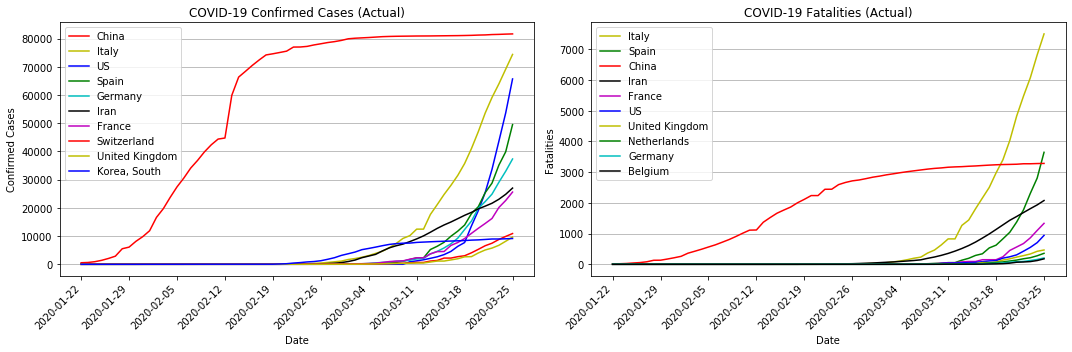

In [22]:
saved_img = os.path.join('images','countries_before.png')
chart_doubles(top_confirmed_df, top_fatalities_df, countries_color, saved_img)

In [23]:
def chart_single(df, output_file):

    # x-axis
    dates = df.columns.tolist()
    days = range(len(dates))

    # y-axis
    regions = df.index                  # list of regions
    top_confirmed = df.values.tolist()  # total confirmed cases

    fig, ax = plt.subplots(figsize = (9,6))
    plt.title("COVID-19 Confirmed Cases (by Region)")
    plt.xlabel("Date")
    plt.ylabel("Confirmed Cases")

    xticks = [day*7 for day in days]
    xlabels = dates[0::7]
    plt.xticks(xticks, xlabels, rotation=45)

    mcolor = ['r','y','b','g','c','k','m']
    counter = 0
    region_labels = ()

    for region in regions:
        ax.plot(days, top_confirmed[counter], label = regions, color = mcolor[counter], linestyle = '-')

        region_labels += (region,)
        counter += 1

        if counter == len(regions):
            break

    plt.legend(region_labels, loc='best')            
    plt.grid(axis='y')
    plt.savefig(output_file)
    plt.tight_layout()
    plt.show()

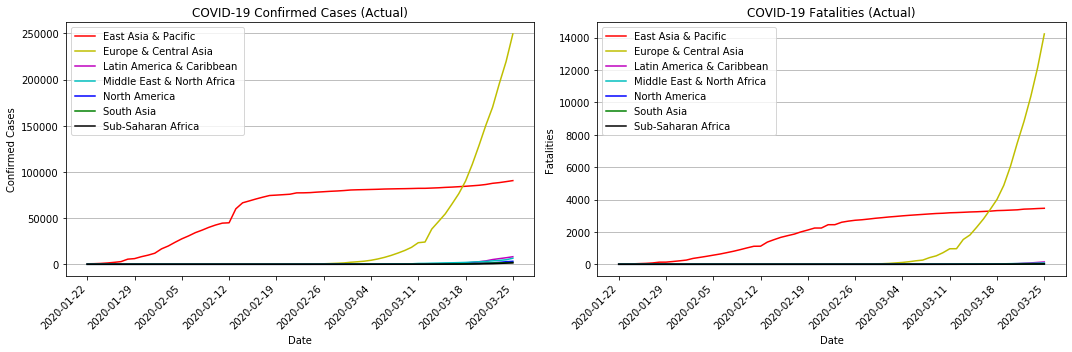

In [17]:
# chart_single(confirmed_r_df, "images/confirmed_regions.png")

saved_img = os.path.join('images','regions_before.png')
chart_doubles(confirmed_r_df, fatalities_r_df, regions_color, saved_img)

## Charting Actual COVID-19 Spread Since First Day

In [18]:
# First Day Values
def first_day(df, country):
    row = list(df.loc[df.index == country].values[0])
    col = next((i for i, j in enumerate(row) if j.any()), None)     
    first_day = df.columns[col]
    return first_day

print(first_day(top_confirmed_df, "Italy"))
print(first_day(top_fatalities_df, "Italy"))

2020-01-31
2020-02-21


In [19]:
# New dataframes with all non-zero values at beginning
def first_day_df(df):

    new_df = pd.DataFrame(columns=days)

    countries = df.index              # list of countries
    for country in countries:
        # Grab the country's row
        y = list(df.loc[df.index == country].values[0])
        # Grab the column index of first non-zero value
        reset_index = next((i for i, j in enumerate(y) if j.any()), None)     
        # Calculate date
        first_day = df.columns[reset_index]
        # Reset first day
        y = y[reset_index:] + y[:reset_index]
        # New rearranged dataframe
        new_df = new_df.append([y])

    # Same countries indexed
    new_df.index = df.index
    new_df = new_df.replace(0,np.NaN)
    
    return new_df

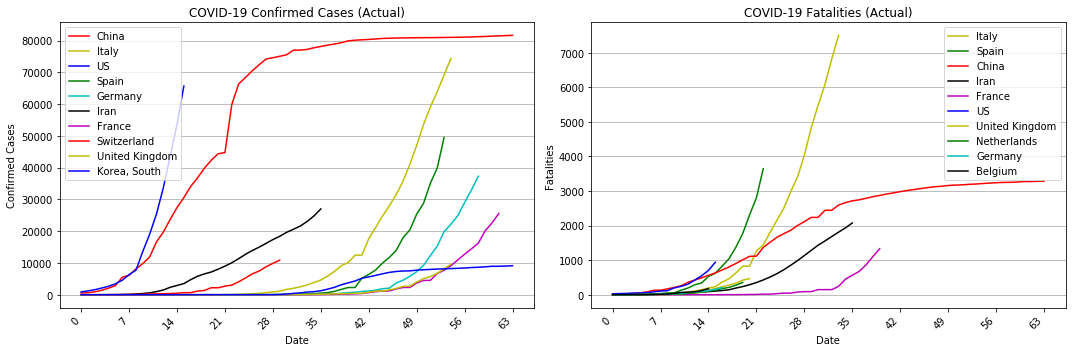

In [25]:
# Confirmed Cases Since First Day
first_confirmed_df = first_day_df(top_confirmed_df)

# Fatalities Since First Day
first_fatalities_df = first_day_df(top_fatalities_df)

# Charts
saved_img = os.path.join('images','countries_byday.png')
chart_doubles(first_confirmed_df, first_fatalities_df, countries_color, saved_img)

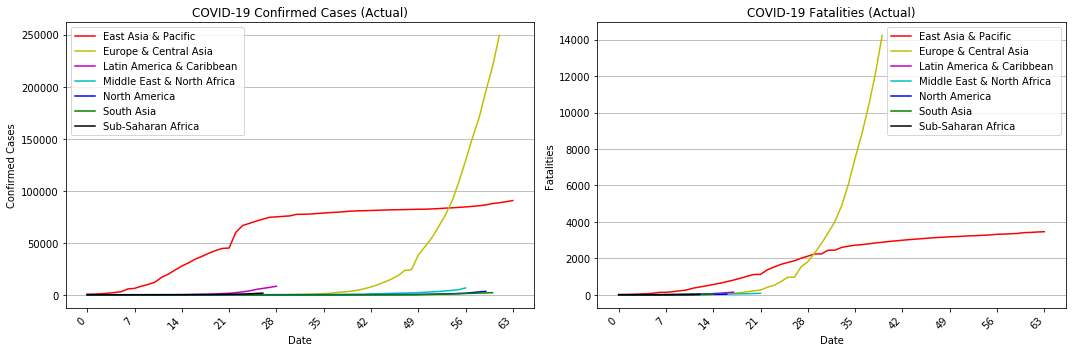

In [27]:
# chart_single(fatalities_r_df, "images/fatalities_regions.png")

first_confirmed_r_df = first_day_df(confirmed_r_df)
first_fatalities_r_df = first_day_df(fatalities_r_df)

saved_img = os.path.join('images','regions_byday.png')
chart_doubles(first_confirmed_r_df, first_fatalities_r_df, regions_color, saved_img)

# Polynomial Regression Model

In [ ]:
# Installations you may need to run this notebook
# !pip install keras
# !pip install tensorflow
# !pip install sklearn --upgrade
# !pip install joblib

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit

## Charting Predicted COVID-19 Spread

In [ ]:
from datetime import datetime as dt

# Prediction Dates
test_data = os.path.join('resources','test.csv')
test_df = pd.read_csv(test_data)

# Start Date
start = test_df['Date'].min()
start = dt.strptime(start, '%Y-%m-%d')

# End Date
end = test_df['Date'].max()
end = dt.strptime(end, '%Y-%m-%d')

# Date Range
n_days = (end-start).days
n_days

In [ ]:
i_days = n_days - 1   # adjust for index
degree = 7

# Subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

# x-axis labels
ax1.set(xlabel="Days Since First Confirmed Case", ylabel="Confirmed Cases")
ax1.set_xticks(xticks) 
ax2.set(xlabel="Days Since First Confirmed Case", ylabel="Fatalities")
ax2.set_xticks(xticks) 

# Chart titles
ax1.set_title("COVID-19 Confirmed Cases (Predictive)")
ax2.set_title("COVID-19 Fatalities (Predictive)")

# Confirmed Cases Line Chart
c_labels = ()
c_counter = 0

first_confirmed = pd.DataFrame(columns=days)

for country in c_countries:
    
    y = top_confirmed_df.loc[top_confirmed_df.index == country].values[0]
   
    c_polynomial = np.poly1d(np.polyfit(days, y, degree))
    c_polyline = np.linspace(0, days[-1], 1000)
#     c_polyline = np.linspace(days[-1], days[-1]+n_days, 1000)
    ax1.plot(c_polyline, c_polynomial(c_polyline), 
             c = line_color[country], 
             label = c_countries)

#     model_score = r2_score(y, c_polynomial(days))
#     prediction = round(c_polynomial(n_days), -3)  # rounded to 1000's

    c_labels += (country,)
    c_counter += 1
        

# Fatalities Line Chart
f_labels = ()
f_counter = 0

for country in f_countries:
    y = top_fatalities_df.loc[top_fatalities_df.index == country].values[0]
    
    f_polynomial = np.poly1d(np.polyfit(days, y, degree))
    f_polyline = np.linspace(0, days[-1], 1000)
#     f_polyline = np.linspace(days[-1], days[-1]+n_days, 1000)
    ax2.plot(f_polyline, f_polynomial(f_polyline), 
             c = line_color[country], 
             label = f_countries)

#     model_score = r2_score(y, f_polynomial(days))
#     prediction = round(f_polynomial(n_days), -3)  # rounded to 1000's
    
    f_labels += (country,)
    f_counter += 1    
    
# Legends and chart style    
ax1.legend(c_labels, loc='best')
ax2.legend(f_labels, loc='best')
ax1.grid(axis='y'), ax2.grid(axis='y')

# Save Image
plt.savefig("images/predicted.png")
plt.tight_layout()
plt.show()

In [ ]:
# # Separate Training Data (80%) to create model v. Test Data (20%) to test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# # Train the model using the training data
# model.fit(X_train, y_train)

# # And score the model using the unseen testing data
# print(f"Training Data Score: {model.score(X_train, y_train)}")
# print(f"Testing Data Score: {model.score(X_test, y_test)}")

## SIR Model

In [ ]:
global_confirmed = confirmed_df.iloc[:,-1].sum()
global_recovered = recovered_df.iloc[:,-1].sum()
global_fatalities = fatalities_df.iloc[:,-1].sum()
print(f"Infected: {global_confirmed}, Removed: {global_recovered + global_fatalities}")

In [ ]:
# Total population, N.
# N = 1000
N = population
# Initial number of infected and recovered individuals, I0 and R0.
# I0, R0 = 0, 1
I0, R0 = global_confirmed, global_recovered + global_fatalities
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# beta, gamma = 0.2, 1./10 
beta, gamma = 0.1, 1./38
# A grid of time points (in days)
# t = np.linspace(0, 160, 160)
t = np.linspace(0, 365, 160)

In [ ]:
from scipy.integrate import odeint

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Population Demographics

In [ ]:
file = os.path.join('resources','demographics','population.csv')
population_df = pd.read_csv(file)
population_df

## Pre-existing Health Conditions/Burden of Disease